# Dynamics of ODEs & Bifurcation Continuation

The [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/)
ecosystem is a collection of packages for solving differential equations.
`OrdinaryDiffEq` is the main package used for systems of ODEs, though
`DiffEqGPU` offers similar functionality for GPU acceleration.

In [2]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

using OrdinaryDiffEq

  Activating project at `~/Dev/siam-student-conf-2025/notebooks`


## Integrate-and-fire neuron model

<div style="background-color: white; text-align: center;">
  <img style="width: 320px;" src="https://neuronaldynamics.epfl.ch/online/x635.png">
</div>

*Image credit: https://neuronaldynamics.epfl.ch/online/Ch1.S3.html*

The integrate-and-fire model is based on a single simple ODE:

$$C\dot{V}(t) = g_{\rm Leak}(V(t)-V_{\rm Rest}) + I_{\rm Ext}(t),$$

where $C$ is the membrane capacitance, $g_{\rm Leak}$ is the membrane leak
conductance, $V_{\rm Rest}$ is the equilibrium potential of the leak channel,
and $I_{\rm Ext}(t)$ is a current applied to the membrane from the outside
world.

There are two extra parameters in the model:
1. $V_{\rm Th}$, a threshold voltage at which the neuron will "spike," or fire
   an action potential upon crossing upward.
2. $V_{\rm AP}$, the maximum voltage value of an action potential.

When an action potential is observed, the voltage $V$ should be immediately
reset to the equilibrium voltage value $V_{\rm Rest}$.

*Note: Formally speaking, the solutions to the integrate-and-fire neuron model
are distributions, where action potentials are instantaneous (Dirac delta
terms).*

### Derivative definition

In [9]:
# Define the differential equation.
# Note: The state V and derivatives dV are vectors (with only one component in
# this model). In general, they may have any number of components.
function integrate_and_fire!(
  dV::Vector{Float64}, # dV/dt. Will be mutated, hence `!` in the function name.
  V::Vector{Float64},  # Voltage.
  p::Vector{Float64},  # Parameter vector.
  t::Float64           # Time.
) # Since we're using an in-place solver, we mutate the existing dV instead of returning a new updated dV.
  # Extract parameters from p.
  C, g_leak, V_rest, _, _ = p
  
  # Compute the derivative.
  # Note: I_ext isn't defined yet -- we can call it here because Julia does
  # two-pass compilation. We'll define it later.
  dV[1] = (g_leak * (V_rest - V[1]) + I_ext(t)) / C;

  # We don't need to return anything for an in-place solver.
  # Also, note that we do NOT handle action potential events in this derivative
  # definition. Instead, we will use a callback injected into the numerical
  # solver -- DifferentialEquations.jl provides rich callback functionality.
  # We only need to define the derivatives for the model here.
end

integrate_and_fire! (generic function with 1 method)

### Callback definition (action potential handling)

https://docs.sciml.ai/DiffEqDocs/stable/features/callback_functions/

In [10]:
# We want to store the spike times. We reset this to nothing later, but
# I defined it here too for pedagogical clarity.
ap_times = Float64[]

# Define the action potential handler callback.
# This will be triggered when the voltage crosses the threshold from below to
# above.
function condition_spike(V, t, integrator)
  # Extract parameters from the integrator.
  _, _, V_rest, V_th, _ = integrator.p
  
  # Return the difference between voltage and threshold.
  # The callback triggers when this crosses zero from negative to positive.
  return V[1] - V_th
end

function affect_spike!(integrator)
  # Extract parameters from the integrator.
  _, _, V_rest, _, _ = integrator.p
  
  # Record that a spike occurred at the current time.
  push!(ap_times, integrator.t)
  
  # Reset voltage to resting potential.
  integrator.u[1] = V_rest
end

# Create the callback that will be passed to the solver.
#
# Because this is a *continuous* callback, `affect_spike!` will be called
# at exactly the time of the spike voltage threshold being crossed, no matter
# the integration time step size.
#
# The `affect_neg!` kwarg needs to be set to `nothing`; otherwise it defaults to
# whatever `affect!` is (in this case, `affect_spike!`). This would cause
# spikes to occur when the spike voltage threshold is crossed from above to
# below.
spike_callback = ContinuousCallback(condition_spike, affect_spike!; affect_neg! = nothing);

### External current

In [143]:
function I_ext(t::Float64)::Float64
  amplitude = 10.0
  period = 20.0

  # amplitude # Constant current.
  amplitude * ((sin(t * π / 2period) + 1.0) / 2.0)^3 # Oscillatory excitatory current.
  # amplitude * floor((t / period) % 2.0) # Periodic pulses.
end

I_ext (generic function with 1 method)

### Parameters & numerical solver config

In [155]:
# Define parameter vector.
p = [
  1.0,   # C
  0.01,  # g_leak
  -60.0, # V_rest
  -40.0, # V_th
  20.0   # V_ap
];
tspan = (0.0, 3e2); # Time span for integration.

### Initial condition

In [156]:
V0 = [p[3]]; # Start with voltage at resting voltage.
ap_times = Float64[]; # Reset spike times vector.

### Solve the system

In [157]:
# Set up the differential equation problem.
prob = ODEProblem(integrate_and_fire!, V0, tspan, p)

# Compute the solution.
sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, callback=spike_callback)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 284-element Vector{Float64}:
   0.0
   0.02176125631892553
   0.23245492140641202
   0.6483645921415518
   1.1531436988007053
   1.7634220037532295
   2.457044195997477
   3.230118126336742
   4.066562294542153
   4.9574936071857225
   ⋮
 286.5001154775818
 288.6786596197479
 290.0797975256339
 291.74214450672076
 293.2411690756605
 294.8296644205109
 296.4284996679966
 298.14876907393494
 300.0
u: 284-element Vector{Vector{Float64}}:
 [-60.0]
 [-59.97273157834622]
 [-59.701720606501055]
 [-59.12828351288084]
 [-58.35987665943147]
 [-57.31713354824124]
 [-55.96881381844362]
 [-54.24446454402497]
 [-52.094059546571465]
 [-49.45297341164379]
 ⋮
 [-48.08371130413204]
 [-48.10662289630718]
 [-48.20953517086045]
 [-48.37284431242169]
 [-48.53647658660166]
 [-48.71446753902907]
 [-48.893011812389915]
 [-49.082410479823814]
 [-49.28266061789893]

### Plot the solution and external current

In [158]:
using GLMakie

In [159]:
# Create a figure with two panels.
fig = Figure(size=(800, 600))

# First panel for voltage.
ax1 = Axis(
  fig[1, 1], 
  xlabel="Time (ms)", 
  ylabel="Voltage (mV)",
  title="Membrane Potential"
)

# Plot the voltage trajectory.
lines!(ax1, sol.t, [u[1] for u in sol.u], linewidth=2, color=:blue)

# Add markers for action potentials.
if !isempty(ap_times)
  # Add vertical lines from threshold to action potential voltage.
  for t in ap_times
    lines!(
      ax1,
      [t, t],
      [p[4], p[5]],
      color=:blue,
      linewidth=2
    )
  end
  
  # Add scatter points at action potential peaks.
  scatter!(
    ax1,
    ap_times,
    fill(p[5], length(ap_times)), 
    color=:red,
    markersize=10
  )
end

# Add a horizontal line for threshold voltage.
hlines!(ax1, p[4], color=:black, linestyle=:dash, label="Threshold")

# Second panel for external current.
ax2 = Axis(
  fig[2, 1], 
  xlabel="Time (ms)", 
  ylabel="Current (nA)",
  title="External Current"
)

# Calculate current at each time point.
current_values = [I_ext(t) for t in sol.t]
lines!(ax2, sol.t, current_values, linewidth=2, color=:green)

# Add a horizontal line at zero current for reference.
hlines!(ax2, 0, color=:black, linestyle=:dash, label="Zero Current")

# Link the x-axes of both panels.
linkxaxes!(ax1, ax2)

# Add some padding to the layout.
fig[1:2, 1] = GridLayout(tellwidth=false)

# Display the figure.
fig

## Lorenz system

The Lorenz system is an autonomous system of three ODEs:

$$\dot{x} = \sigma(y-t),$$
$$\dot{y} = x(\rho-z)-y,$$
$$\dot{z} = xy-\beta z.$$

For parameter values $\rho = 28, \sigma = 10, \beta = \frac83$, the system
exhibits a chaotic attractor.

We'll try to locate some periodic orbits in the state space of the Lorenz
system using parameter continuation with `BifurcationKit.jl`.

### Define derivatives

In [3]:
function lorenz!(du, u, p, t)
  # Extract parameters.
  ρ, σ, β = p

  # Extract state variables.
  x, y, z = u
  
  # Define the Lorenz system equations.
  du[1] = σ * (y - x)
  du[2] = x * (ρ - z) - y
  du[3] = x * y - β * z

  # Return the derivatives; we will need this for BifurcationKit.jl.
  du
end

lorenz! (generic function with 1 method)

### Set up integration

In [4]:
p = [
  28.0,   # ρ
  10.0,   # σ
  8.0/3.0 # β
]

u0 = [
  10.0, # x
  10.0, # y
  10.0  # z
]

tspan = (0.0, 1e4)

(0.0, 10000.0)

### Integrate

In [174]:
# Create the ODE problem.
prob = ODEProblem(lorenz!, u0, tspan, p)

# Solve the ODE problem.
solution = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/chinsley1@gsuad.gsu.edu/.julia/packages/SciMLBase/elLNZ/src/integrator_interface.jl:589


retcode: MaxIters
Interpolation: specialized 4th order "free" interpolation
t: 1000001-element Vector{Float64}:
    0.0
    0.0037878943279583423
    0.00654267995721159
    0.010474196238476254
    0.014332074224139806
    0.018791321812050864
    0.02343892222162853
    0.028464232997098098
    0.03373296219106319
    0.039293057143494306
    ⋮
 8175.206076147614
 8175.212237905411
 8175.218440538138
 8175.224693966821
 8175.231007746806
 8175.237391327612
 8175.243854505026
 8175.2504080883045
 8175.257064829942
u: 1000001-element Vector{Vector{Float64}}:
 [10.0, 10.0, 10.0]
 [10.011963665785023, 10.637602794596228, 10.288614042710618]
 [10.035201595986022, 11.093620267046223, 10.512236050144764]
 [10.088465920032927, 11.73375641349154, 10.851737916064584]
 [10.162504870374022, 12.350140985354296, 11.208647613187068]
 [10.273309536041564, 13.048449457689548, 11.651357617918107]
 [10.415683482560844, 13.760149528977141, 12.148321690361675]
 [10.598230183685047, 14.51074855056456, 12.

### Plot solution

In [175]:
# Extract the solution components.
xs = [u[1] for u in solution.u]
ys = [u[2] for u in solution.u]
zs = [u[3] for u in solution.u]

# Create the 3D plot.
fig = Figure()
ax = Axis3(
  fig[1, 1], 
  xlabel = "x", 
  ylabel = "y", 
  zlabel = "z",
  title = "Lorenz system trajectory"
)

# Plot the solution.
lines!(ax, xs, ys, zs, linewidth = 1)

# Display the figure.
fig

### Set up `BifurcationKit.jl` for Lorenz system

In [6]:
using BifurcationKit

We need to give BifurcationKit.jl a good initial guess for the location of an
equilibrium.
I used [Fork](https://fork-phi.vercel.app) to find an equilibrium I want to
continue, though you can just use Newton method in Julia if you want.
We use the usual parameter values (from earlier) as the starting point.

In [5]:
# Initial guess for the equilibrium point.
u0 = [
  8.48528137423857, # x
  8.48528137423857, # y
  27.0              # z
]

3-element Vector{Float64}:
  8.48528137423857
  8.48528137423857
 27.0

In [7]:
# Out-of-place derivatives for bifurcation continuation.
function lorenz_bifn(u, p)
  # Extract parameters.
  ρ, σ, β = p

  # Extract state variables.
  x, y, z = u
  
  # Define the Lorenz system equations.
  du = [
    σ * (y - x),
    x * (ρ - z) - y,
    x * y - β * z
  ]

  # Return the derivatives.
  du
end

lorenz_bifn (generic function with 1 method)

In [8]:
# We're going to do an equilibrium continuation with respect to the β parameter
# (parameter 3).
bifn_prob = BifurcationProblem(lorenz_bifn, u0, p, 3)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace:  false
├─ Dimension:  3
├─ Symmetric: false
└─ Parameter: p

In [9]:
# Specify a continuation range.
#
# We want to continue β in the positive direction.
opts_br = ContinuationPar(p_min = 8.0/3.0, p_max = 4.0)

ContinuationPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  dsmin: Float64 0.0001
  dsmax: Float64 0.1
  ds: Float64 0.01
  a: Float64 0.5
  p_min: Float64 2.6666666666666665
  p_max: Float64 4.0
  max_steps: Int64 400
  newton_options: NewtonPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  η: Float64 150.0
  save_to_file: Bool false
  save_sol_every_step: Int64 1
  nev: Int64 3
  save_eig_every_step: Int64 1
  save_eigenvectors: Bool true
  plot_every_step: Int64 10
  tol_stability: Float64 1.0e-10
  detect_fold: Bool true
  detect_bifurcation: Int64 3
  dsmin_bisection: Float64 1.0e-16
  n_inversion: Int64 2
  max_bisection_steps: Int64 25
  tol_bisection_eigenvalue: Float64 1.0e-16
  detect_event: Int64 0
  tol_param_bisection_event: Float64 1.0e-16
  detect_loop: Bool false


### Continue the equilibrium with respect to $\beta$ to find Hopf bifurcation

In [10]:
br = continuation(bifn_prob, MoorePenrose(), opts_br; normC = norminf)

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 21
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter p starts at 2.6666666666666665, ends at 4.0
 ├─ Algo: MoorePenrose
 └─ Special points:

- #  1,     hopf at p ≈ +3.22890052 ∈ (+3.20608122, +3.22890052), |δp|=2e-02, [converged], δ = (-2, -2), step =  11
- #  2, endpoint at p ≈ +4.00000000,                                                                     step =  20


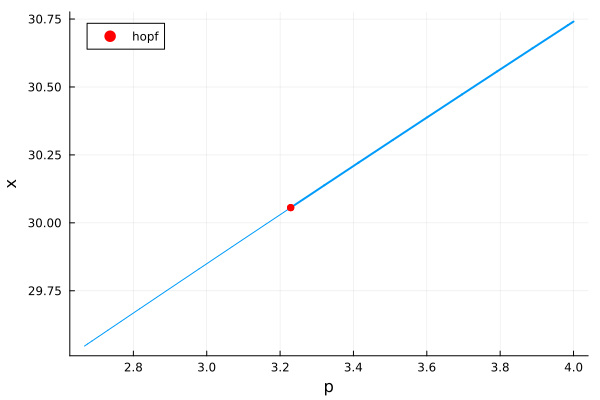

In [11]:
# BifurcationKit.jl does support Makie, but the documentation primarily uses
# Plots.jl.
using Plots

scene = plot(br, plotfold=false, markersize=4, legend=:topleft)

### Continue the periodic orbit with respect to $\beta$ back to a Neimark-Sacker bifurcation

In [68]:
# Tell the continuation problem what to record from the solutions at each
# parameter value (the periodic orbit as a trajectory).
args_po = (
  record_from_solution = (u, p; k...) -> begin
    utt = get_periodic_orbit(p.prob, u, p.p)
    return (
      utt = utt,
      period = getperiod(p.prob, u, p.p)
    )
  end,
  normC = norminf
)

# Configure the continuation problem.
opts_po_cont = ContinuationPar(
  opts_br,
  ds=-3e-3,
  dsmin=1e-4,
  dsmax=1e-1,
  max_steps=50,
  tol_stability=1e-7
)

# Make sure the continuation has an appropriate tolerance; otherwise it won't
# converge.
@reset opts_po_cont.newton_options.tol = 1e-7

# Perform the continuation with periodic orbit collocation.
br_po = continuation(
  br,
  1,
  opts_po_cont,
  PeriodicOrbitOCollProblem(100, 4; meshadapt=true)
)
# br_po = continuation(br, 1, opts_po_cont, PeriodicOrbitTrapProblem(M=250))

 ┌─ Curve type: PeriodicOrbitCont from Hopf bifurcation point.
 ├─ Number of points: 51
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter p starts at 3.231900523059763, ends at 3.010882862665239
 ├─ Algo: MoorePenrose
 └─ Special points:

- #  1,       ns at p ≈ +3.21052179 ∈ (+3.21052179, +3.21052687), |δp|=5e-06, [converged], δ = ( 2,  2), step =  11
- #  2, endpoint at p ≈ +3.00584802,                                                                     step =  51


### Plot periodic orbit

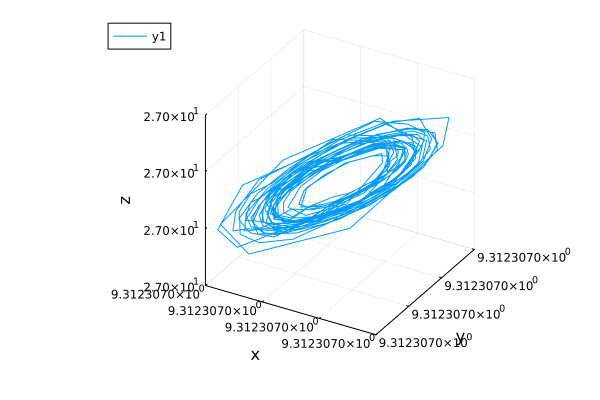

In [73]:
# Plot exactly at NS bifurcation (false)? Or after some further continuation
# (true)?
after_neimark_sacker = false

endpoint_step = br_po.specialpoint[after_neimark_sacker ? end : 1].step
po_traj = get_periodic_orbit(br_po, endpoint_step)

plot(
  po_traj[1,:],
  po_traj[2,:],
  po_traj[3,:],
  xlabel="x",
  ylabel="y",
  zlabel="z",
  linewidth=1
)

### PCA and plot in GLMakie for clearer visual

In [74]:
using GLMakie, LinearAlgebra, MultivariateStats, Statistics

# Extract the raw data from po_traj
x_coords = po_traj[1, :]
y_coords = po_traj[2, :]
z_coords = po_traj[3, :]

# Create a matrix where each column is a dimension (x,y,z) and each row is a point
data_matrix = hcat(x_coords, y_coords, z_coords)

# Center the data (subtract mean)
data_centered = data_matrix .- mean(data_matrix, dims=1)

# Calculate the covariance matrix manually
cov_matrix = (data_centered' * data_centered) ./ (size(data_centered, 1) - 1)

# Perform eigen decomposition
eigen_vals, eigen_vecs = eigen(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
idx = sortperm(eigen_vals, rev=true)
eigen_vals = eigen_vals[idx]
eigen_vecs = eigen_vecs[:, idx]

# Project the data onto the principal components
pca_data = data_centered * eigen_vecs

# Calculate explained variance ratio
total_variance = sum(eigen_vals)
explained_variance_ratio = eigen_vals ./ total_variance

# Create a 3D plot of the projected data using GLMakie.
fig = Figure()
ax = Axis3(fig[1, 1], 
    xlabel="PC1 ($(round(explained_variance_ratio[1]*100, digits=2))%)",
    ylabel="PC2 ($(round(explained_variance_ratio[2]*100, digits=2))%)",
    zlabel="PC3 ($(round(explained_variance_ratio[3]*100, digits=2))%)",
    title="3D PCA of Periodic Orbit"
)
lines!(ax, pca_data[:, 1], pca_data[:, 2], pca_data[:, 3], linewidth=1)
fig
